In [1]:
s3_data ="s3://aegovan-data/processed_dataset/test_unique_negative_entity_only.json"
model_s3_path="s3://aegovan-data/results/ppi-bert-untype-2019-11-05-08-14-14-416/output/output.tar.gz"

s3_model_path_format = "s3://aegovan-data/results/{}/output/output.tar.gz"

In [2]:
!pip install scikit-plot==0.3.7

You should consider upgrading via the 'pip install --upgrade pip' command.


In [3]:
import tarfile
import pandas as pd
import json
from pandas.io.json import json_normalize
import tempfile 
import os
import boto3
import matplotlib.pyplot as plt
import glob
from sklearn.metrics import f1_score, accuracy_score,precision_score, recall_score
import scikitplot as skplt





In [4]:


pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 10000)
pd.set_option('display.max_rows', 100)

plt.rcParams.update({'font.size': 12})

In [5]:

def download_single_file(bucket_name_path, local_path):
    index = bucket_name_path.find("://")

    # remove the s3:// if present
    if index > -1:
        bucket_name_path = bucket_name_path[index + 3:]

    key_start_index = bucket_name_path.find("/")
    bucket_name = bucket_name_path
    key = "/"
    if key_start_index > -1:
        bucket_name = bucket_name_path[0:key_start_index]
        key = bucket_name_path[key_start_index + 1:]
        
    client = boto3.resource('s3')
    client.Bucket(bucket_name).download_file(key, local_path)



In [6]:
def load_scores_as_df (file):
    with open(file, "r") as i:
        data = json.loads(i.read())
        
    return json_normalize(data)

In [7]:


def get_predictions(s3_path):
    tmp_dir = tempfile.mkdtemp()
    outfile = os.path.join(tmp_dir, "output.tar.gz" )
    download_single_file(s3_path, outfile)
    tf = tarfile.open(outfile)
    tf.extractall(path=tmp_dir)
    test_input_file = os.path.join(tmp_dir, "predicted.json")


    df_results =  pd.read_json(test_input_file)
    df_results["actual"] = df_results["isValid"]
    
    validation_fit_file = glob.glob("{}/validation_scores_epoch_Objectdump*.json".format(tmp_dir))[0]
    train_fit_file = glob.glob("{}/training_scores_epoch_Objectdump*.json".format(tmp_dir))[0]

    df_val_fit = load_scores_as_df(validation_fit_file)
    df_train_fit = load_scores_as_df(train_fit_file)



    return df_results, df_val_fit, df_train_fit

In [8]:

def convert_scores_to_df(scores : dict):
    score_formatted = []
    for k, v in scores.items():
        p,r,f1 = v[0], v[1], v[2]
        score_formatted.append ({"key":k, "Precision": p*100, "Recall":r*100, "F1-score": f1*100})
    return pd.DataFrame(score_formatted)

In [9]:
def get_all_scores (list_of_s3_path):
    scores = []

    for s3_path in list_of_s3_path:
        df,_,_ = get_predictions(s3_path) 
        score = {}
        score["key"]=s3_path
        score["F1-score"] = 100*f1_score(df["actual"], df["predicted"], average='binary' ,sample_weight=None)  
        score["Precision"]  =100* precision_score(df["actual"], df["predicted"], average='binary' ,sample_weight=None)  
        score["Recall"] = 100*recall_score(df["actual"], df["predicted"], average='binary' ,sample_weight=None)  
        scores.append(score)
        
    return pd.DataFrame(scores)




In [10]:

pos_label = True
df_results, df_val_fit, df_train_fit = get_predictions(model_s3_path)

In [11]:
df_results.columns


Index(['entityMentionsCount', 'hasTriggerWord', 'interactionId',
       'interactionType', 'isValid', 'lessThanThreshold', 'participant1Alias',
       'participant1Id', 'participant2Alias', 'participant2Id',
       'participants_count', 'pubmedId', 'pubmedTitle', 'pubmedabstract',
       'normalised_abstract', 'particpant1Exists', 'particpant2Exists',
       'bothParticpantsExist', 'noParticpantsExist', 'predicted',
       'confidence_scores', 'actual'],
      dtype='object')

In [12]:
df_results.shape

(894, 22)

In [13]:
df_results.head(n=1)

,entityMentionsCount,hasTriggerWord,interactionId,interactionType,isValid,lessThanThreshold,participant1Alias,participant1Id,participant2Alias,participant2Id,participants_count,pubmedId,pubmedTitle,pubmedabstract,normalised_abstract,particpant1Exists,particpant2Exists,bothParticpantsExist,noParticpantsExist,predicted,confidence_scores,actual
0,5,True,1012878_e8728d51-a879-40dd-9f42-aeb3aa715354_fake_annot,dephosphorylation,False,True,[PP2A],Q15257,"[MAPK/ERK kinase kinase 3, MEKK3]",Q99759,2,16407301,None,"MAPK/ERK kinase kinase 3 (MEKK3) is a mitogen-activated protein kinase kinase kinase (MAP3K) that functions upstream of the MAP kinases and IkappaB kinase. Phosphorylation is believed to be a critical component for MEKK3-dependent signal transduction, but little is known about the phosphorylation sites of this MAP3K. To address this question, point mutations were introduced in the activation loop (T-loop), substituting alanine for serine or threonine, and the mutants were transfected into HEK293 Epstein-Barr virus nuclear antigen cells. MEKK3-dependent activation of an NF-kappaB reporter gene as well as ERK, JNK, and p38 MAP kinases correlated with a requirement for serine at position 526. Constitutively active mutants of MEKK3, consisting of S526D and S526E, were capable of activating a NF-kappaB luciferase reporter gene as well as ERK and MEK, suggesting that a negative charge at Ser526 was necessary for MEKK3 activity and implicating Ser526 as a phosphorylation site. An antibody was developed that specifically recognized phospho-Ser526 of MEKK3 but did not recognize the S526A point mutant. The catalytically inactive (K391M) mutant of MEKK3 was not phosphorylated at Ser526, indicating that phosphorylation of Ser526 occurs via autophosphorylation. Endogenous MEKK3 was phosphorylated on Ser526 in response to osmotic stress. In addition, phosphorylation of Ser526 was required for MKK6 phosphorylation in vitro, whereas dephosphorylation of Ser526 was mediated by protein phosphatase 2A and sensitive to okadaic acid and sodium fluoride. Finally, the association between MEKK3 and 14-3-3 was dependent on Ser526 and prevented dephosphorylation of Ser526. In summary, Ser526 of MEKK3 is an autophosphorylation site within the T-loop that is regulated by PP2A and 14-3-3 proteins.","Q99759 (Q99759) is a mitogen-activated protein kinase kinase kinase (MAP3K) that functions upstream of the MAP kinases and IkappaB kinase. Phosphorylation is believed to be a critical component for Q99759-dependent signal transduction, but little is known about the phosphorylation sites of this MAP3K. To address this question, point mutations were introduced in the activation loop (T-loop), substituting alanine for serine or threonine, and the mutants were transfected into HEK293 Epstein-Barr virus nuclear antigen cells. Q99759-dependent activation of an NF-kappaB reporter gene as well as ERK, JNK, and Q16539 MAP kinases correlated with a requirement for serine at position 526. Constitutively active mutants of Q99759, consisting of S526D and S526E, were capable of activating a NF-kappaB luciferase reporter gene as well as ERK and O14733, suggesting that a negative charge at Ser526 was necessary for Q99759 activity and implicating Ser526 as a phosphorylation site. An antibody was developed that specifically recognized phospho-Ser526 of Q99759 but did not recognize the S526A point mutant. The catalytically inactive (K391M) mutant of Q99759 was not phosphorylated at Ser526, indicating that phosphorylation of Ser526 occurs via autophosphorylation. Endogenous Q99759 was phosphorylated on Ser526 in response to osmotic stress. In addition, phosphorylation of Ser526 was required for P52564 phosphorylation in vitro, whereas dephosphorylation of Ser526 was mediated by protein phosphatase 2A and sensitive to okadaic acid and sodium fluoride. Finally, the association between Q99759 and 14-3-3 was dependent on Ser526 and prevented dephosphorylation of Ser526. In summary,

## Analyse Results

In [14]:
df = df_results

In [15]:
df_results.shape

(894, 22)

In [16]:
keys = list(df["confidence_scores"][0].keys())

In [17]:
import math

# This is log softmax, convert to softmax prob
for k in keys:
    df[k]  =df["confidence_scores"].apply(lambda x: math.exp(x[k]))
    df[k]  =df["confidence_scores"].apply(lambda x: math.exp(x[k]))

df["predicted_confidence"] = df.apply(lambda r: max(r[ keys]/ sum(r[ keys])), axis=1 )

In [18]:
df[ ["predicted_confidence"] + keys].sample(n=10)

,predicted_confidence,False,True
143,0.999897,117.625140,0.012113
208,0.998887,35.595658,0.039662
478,0.999911,132.167041,0.011727
431,0.999902,144.290751,0.014125
883,0.999858,135.814266,0.019324
868,0.999034,0.034663,35.862780
315,0.999911,140.755031,0.012525
523,0.999448,69.184861,0.038190
878,0.999557,75.670714,0.033510
263,0.999917,127.730328,0.010664


In [19]:
from sklearn.metrics import f1_score, accuracy_score,precision_score, recall_score

scores = {}
scores["F1_binary"] = f1_score(df["actual"], df["predicted"], average='binary' ,sample_weight=None)  
scores["precision_binary"]  = precision_score(df["actual"], df["predicted"], average='binary' ,sample_weight=None)  
scores["recall_binary"] = recall_score(df["actual"], df["predicted"], average='binary' ,sample_weight=None)  





scores["accuracy"] = accuracy_score(df["actual"], df["predicted"],sample_weight=None)
print(scores)



{'F1_binary': 0.7239583333333335, 'precision_binary': 0.7808988764044944, 'recall_binary': 0.6747572815533981, 'accuracy': 0.8814317673378076}


In [20]:

accuracy = accuracy_score(df["actual"], df["predicted"], sample_weight=None)
f1 = f1_score(df["actual"], df["predicted"],average='macro', sample_weight=None)  



print("The F1 score is {} and the accuracy is {}".format(f1, accuracy))


The F1 score is 0.824229878917379 and the accuracy is 0.8814317673378076


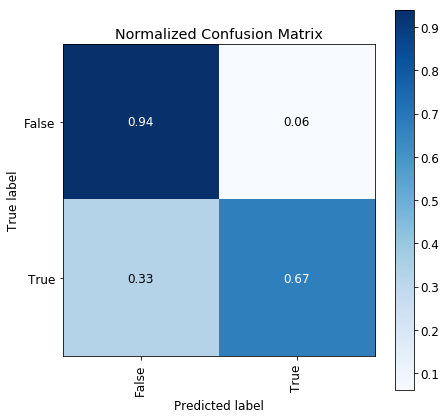

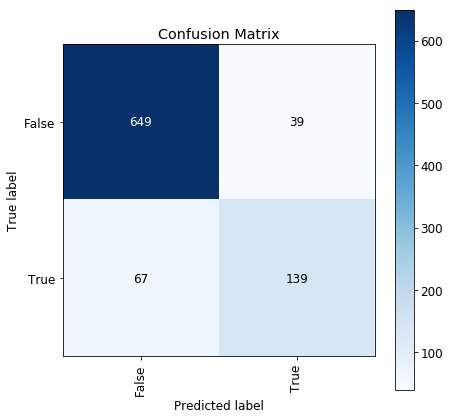

In [21]:
import matplotlib.pyplot as plt
import scikitplot as skplt

# fig = plt.figure(figsize=(7,20))
# gs = fig.add_gridspec(2, 1)


skplt.metrics.plot_confusion_matrix(df["actual"], df["predicted"], normalize=True , figsize=(7,7),  x_tick_rotation=90)
plt.savefig("confusionmatrix_normalised.eps", bbox_inches='tight')

skplt.metrics.plot_confusion_matrix(df["actual"], df["predicted"], figsize=(7,7), normalize=False, x_tick_rotation=90 )
plt.savefig("confusionmatrix_unnormalised.eps", bbox_inches='tight')




In [22]:
# from sklearn.metrics import accuracy_score, accuracy_score,recall_score


# interactions = df["class"].unique()
# interactions.sort()
# #fig, ax = plt.subplots(1, len(interactions), figsize=(40,40), squeeze=False, sharey=True, sharex=True)
# fig = plt.figure(figsize=(20,20))
# gs = fig.add_gridspec(3, 3)
# #ax = fig.add_axes([0,0,1,1])
# i = 0
# avg = 'macro'
# for interaction in interactions:
#     r = i//3
#     c= i % 3
#     df_interaction_type = df.query("predicted == '{}'".format(interaction))
#     if df_interaction_type.shape[0] == 0: continue
#     ax1 = fig.add_subplot(gs[r, c])
    


#     f1 = f1_score(df_interaction_type["actual"], df_interaction_type["predicted"],average=avg, sample_weight=None)  
#     accuracy = accuracy_score(df_interaction_type["actual"], df_interaction_type["predicted"], sample_weight=None)
#     precision= precision_score(df_interaction_type["actual"], df_interaction_type["predicted"], average=avg,sample_weight=None)
#     recall = recall_score(df_interaction_type["actual"], df_interaction_type["predicted"], average=avg,sample_weight=None)
#     skplt.metrics.plot_confusion_matrix(df_interaction_type["actual"], df_interaction_type["predicted"], normalize=False, title = "{}: \nPrecision {}, Recall {} \nF-score {}".format(interaction,  round(precision*100, 2),round(recall*100, 2), round(f1*100, 2)), ax= ax1)
    
# #     ax2 = fig.add_subplot(gs[i, 1])
# #     skplt.metrics.plot_confusion_matrix(df_interaction_type["actual"], df_interaction_type["predicted"], normalize=False, title = "{}: F-score {}".format(interaction,f1), ax= ax2)


#     i += 1
#     #break

# plt.savefig("confusionmatrix_.jpg", bbox_inches='tight')
# plt.show()
    
    


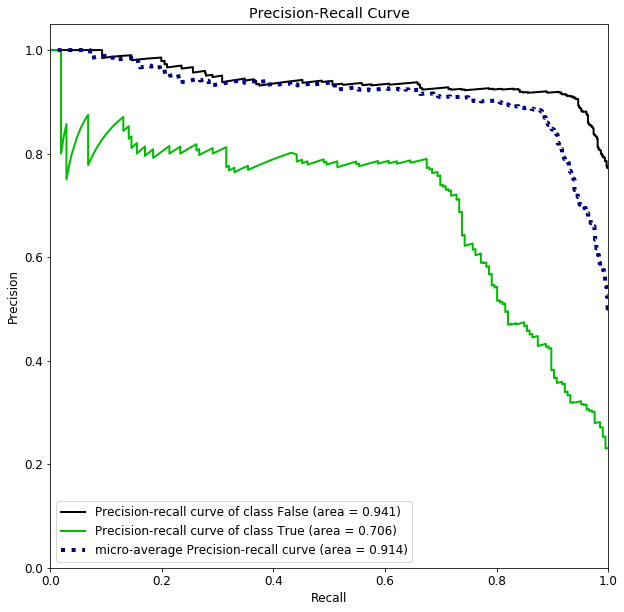

In [23]:


skplt.metrics.plot_precision_recall(df["actual"], df[keys], figsize=(10,10))

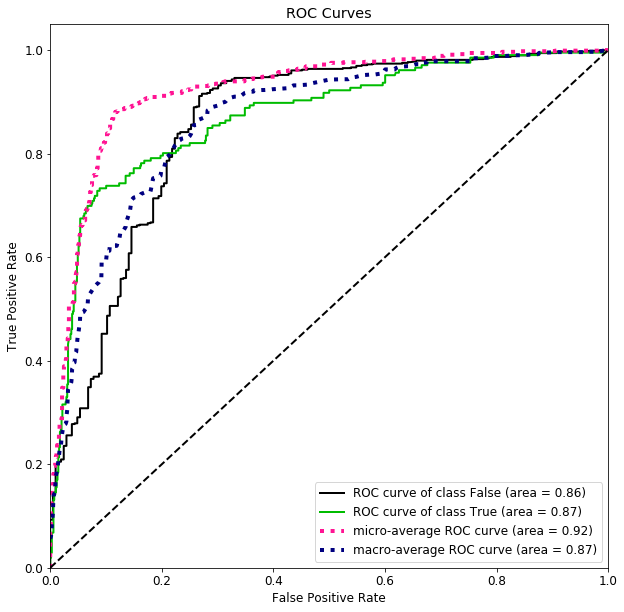

In [24]:

skplt.metrics.plot_roc(df["actual"], df[keys], figsize=(10,10))

## Training / Validation epoch fit

In [25]:
df_train_fit["score"] =df_train_fit["score"]* 100
df_train_fit.sort_values(["score"], ascending=False).head(n=10)

,epoch,loss,score
38,38,0.897991,99.879101
32,32,1.240311,99.839112
44,44,0.899853,99.838988
39,39,0.879323,99.838988
42,42,0.868681,99.838864
41,41,0.895303,99.838864
36,36,0.920220,99.838864
37,37,1.096133,99.838740
24,24,1.969661,99.798968
33,33,1.446311,99.798813


In [26]:
df_val_fit["score"] =df_val_fit["score"]* 100


df_val_fit.sort_values(["score"], ascending=False).head(n=10)

,epoch,loss,score
23,23,43.315627,83.083815
12,12,32.924648,82.823337
33,33,41.870604,82.532731
41,41,45.744951,82.268254
43,43,49.297639,82.207657
22,22,42.464401,82.005549
20,20,37.656112,82.005549
19,19,34.510314,81.830764
15,15,38.225885,81.794528
44,44,43.496057,81.623464


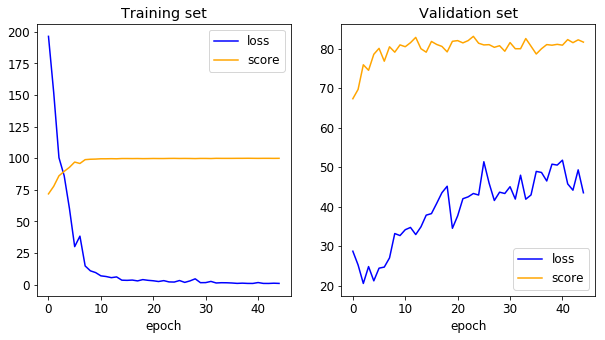

In [27]:
fig, ax = plt.subplots(1,2, figsize=(10,5))

df_train_fit.plot.line(x="epoch", y="loss", ax = ax[0], color ="blue")
df_train_fit.plot.line(x="epoch", y="score", ax = ax[0], color="orange")
ax[0].set_title("Training set")
#ax[0].yaxis.set_major_locator(plt.FixedLocator([0,.1,.2,.3,.4,.5,.6, .7,.8,.9,1]))

df_val_fit.plot.line(x="epoch", y="loss", ax = ax[1], color="blue")
df_val_fit.plot.line(x="epoch", y="score", ax = ax[1], color ="orange")
ax[1].set_title("Validation set")
#ax[1].yaxis.set_major_locator(plt.FixedLocator([0,.1,.2,.3,.4,.5,.6, .7,.8,.9,1]))



plt.show()

### Threshold 

In [28]:
threshold = .00
key = keys[0]
df_trues = df.query("predicted_confidence >  {} and predicted == 'acetylation'".format(threshold))
print(df_trues.shape)

from sklearn.metrics import f1_score, accuracy_score,precision_score, recall_score

f1 = f1_score(df_trues["actual"], df_trues["predicted"], average="macro")  
accuracy = accuracy_score(df_trues["actual"], df_trues["predicted"], sample_weight=None)
precision = precision_score(df_trues["actual"], df_trues["predicted"], average="macro", sample_weight=None)
recall = recall_score(df_trues["actual"], df_trues["predicted"], average="macro", sample_weight=None)



print("The F1 score is {} and the accuracy is {}, precision {}, recall {}".format(f1, accuracy, precision, recall))

(0, 25)
The F1 score is nan and the accuracy is nan, precision nan, recall nan


/Users/aeg/miniconda/envs/kegg_env/lib/python3.7/site-packages/numpy/lib/function_base.py:390: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/Users/aeg/miniconda/envs/kegg_env/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [29]:
interactions = df_trues["interactionType"].unique()
#fig, ax = plt.subplots(1, len(interactions), figsize=(40,40), squeeze=False, sharey=True, sharex=True)
fig = plt.figure(figsize=(40,40))
gs = fig.add_gridspec(7, 1)
#ax = fig.add_axes([0,0,1,1])
i = 0
for interaction in interactions:
    print(interaction)
    df_interaction_type = df_trues.query("interactionType == '{}'".format(interaction))
    ax1 = fig.add_subplot(gs[i, 0])
    


    f1 = f1_score(df_interaction_type["actual"], df_interaction_type["predicted"], average='macro')  
    accuracy = accuracy_score(df_interaction_type["actual"], df_interaction_type["predicted"], sample_weight=None)
    skplt.metrics.plot_confusion_matrix(df_interaction_type["actual"], df_interaction_type["predicted"], normalize=False, title = "{}: F-score {}".format(interaction,f1), ax= ax1)
    
#     ax2 = fig.add_subplot(gs[i, 1])
#     skplt.metrics.plot_confusion_matrix(df_interaction_type["actual"], df_interaction_type["predicted"], normalize=False, title = "{}: F-score {}".format(interaction,f1), ax= ax2)


    i += 1
    #break

plt.savefig("confusionmatrix_threshold.eps", bbox_inches='tight')
    

<Figure size 2880x2880 with 0 Axes>

## Filter uniprot not in train

In [30]:
df_train = pd.read_json('train_unique_pub_v6_less_negative.json')

In [31]:
df_train['participant1Id'].values.tolist()[0:10]

['O43293-1',
 'O43293-2',
 'O60934',
 'P53235',
 'P51617',
 'Q9NWZ3',
 'P51617',
 'Q9H0H5',
 'Q9H0H5',
 'Q9H0H5']

In [32]:
train_uniprot = set(df_train['participant1Id'].values.tolist()).union(set(df_train['participant2Id'].values.tolist()))

In [33]:
df_filtered_uniprot =df[ df.apply(lambda r : r['participant2Id'] in train_uniprot and  r['participant1Id'] in train_uniprot , axis=1)]

In [34]:
df_filtered_uniprot.shape

(454, 25)

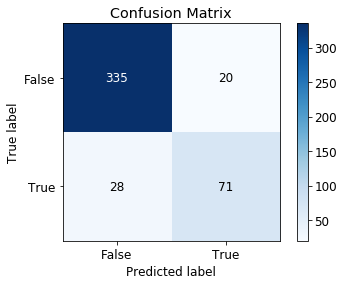

In [35]:
import matplotlib.pyplot as plt
import scikitplot as skplt

skplt.metrics.plot_confusion_matrix(df_filtered_uniprot["actual"], df_filtered_uniprot["predicted"], normalize=False )
plt.show()

In [36]:
from sklearn.metrics import f1_score, accuracy_score

f1 = f1_score(df_filtered_uniprot["actual"], df_filtered_uniprot["predicted"], sample_weight=None)  
accuracy = accuracy_score(df_filtered_uniprot["actual"], df_filtered_uniprot["predicted"], sample_weight=None)
print("The F1 score is {} and the accuracy is {}".format(f1, accuracy))




The F1 score is 0.7473684210526317 and the accuracy is 0.8942731277533039


## Variation Bert

In [37]:
import boto3
import re

def search_log(stream_names, filter_pattern, regex_pattern):
    client = boto3.client('logs')

    log_group_name= "/aws/sagemaker/TrainingJobs"

    response = client.filter_log_events(
        logGroupName=log_group_name,
        logStreamNames=stream_names,
        filterPattern= filter_pattern,
        limit=10,
        interleaved=False
    )
    assert len(response["events"]) == 1
    log_message = response["events"][0]["message"]
    
    # extract the cm from string
    prog = re.compile(regex_pattern)
    result = prog.match(log_message)
    
    return result



def get_prf(stream_names, filterPattern):
    regex_pattern = ".*precision, recall, fscore, support\s+\((0\.\d+,\s+0\.\d+,\s+0\.\d+).*"
    
    result = search_log(stream_names, filterPattern, regex_pattern).group(1)

    # normalise string to remove extra space
    result = re.sub("\s+", "", result) 
    
    # split the string, sep by comma..514 62 41 75
    precision, recall, fscore = result.split(",")
    
    return float(precision), float(recall), float(fscore)


    
def get_val_macro_score(stream_names):
    filterPattern =  '"__main__ - INFO - macro average scores"'
    return get_prf(stream_names, filterPattern)

def get_val_micro_score(stream_names):
    filterPattern =  '"__main__ - INFO - micro average scores"'
    return get_prf(stream_names, filterPattern)

def get_val_binary_score(stream_names):
    filterPattern =  '"__main__ - INFO - binary average scores"'
    return get_prf(stream_names, filterPattern)

def get_log_name(sagemaker_job_name):
    client = boto3.client('logs')
    log_group_name= "/aws/sagemaker/TrainingJobs"
    
    response = client.describe_log_streams(
    logGroupName=log_group_name,
    logStreamNamePrefix=sagemaker_job_name,
    orderBy='LogStreamName',
    descending=False,
    limit=5
)
    assert len(response["logStreams"]) == 1
    
    return  response["logStreams"][0]["logStreamName"]

In [38]:
jobs = [
"ppi-bert-untype-2020-03-09-03-26-08-266",
"ppi-bert-untype-2020-03-09-03-25-30-551",
"ppi-bert-untype-2020-03-09-03-25-04-734",
"ppi-bert-untype-2020-03-09-03-24-40-775",
"ppi-bert-untype-2020-03-09-03-24-18-001",
"ppi-bert-untype-2020-03-09-03-23-52-024",
"ppi-bert-untype-2020-03-09-03-23-29-379",
"ppi-bert-untype-2020-03-09-03-23-07-482",
"ppi-bert-untype-2020-03-09-03-22-50-158",
"ppi-bert-untype-2020-03-09-03-22-27-135"
]

In [39]:
# #precision, recall, fscore
# val_scores = {
#     "ppi-bert-untype-2019-11-05-08-14-14-416-copy-3/algo-1-1573202144":[0.804347826,0.704761905,0.751269036],
#     "ppi-bert-untype-2019-11-05-08-14-14-416-copy-2/algo-1-1573202128": [0.694736842,0.628571429,0.66],
#     "ppi-bert-untype-2019-11-05-08-14-14-416-copy-11-08/algo-1-1573202119":[0.752293578,0.780952381,0.76635514],
#     "ppi-bert-untype-2019-11-05-08-14-14-416-copy-5/algo-1-1573264923": [0.7346938775510204, 0.6857142857142857, 0.7093596059113301],
#     "ppi-bert-untype-2019-11-05-08-14-14-416-copy-6/algo-1-1573264942":[0.75, 0.7714285714285715, 0.7605633802816902],
#     "ppi-bert-untype-2019-11-05-08-14-14-416-copy-7/algo-1-1573264962": [0.7217391304347827, 0.7904761904761904, 0.7545454545454545],
#     "ppi-bert-untype-2019-11-05-08-14-14-416-copy-8/algo-1-1573264983": [0.7373737373737373, 0.6952380952380952, 0.7156862745098039],
#     "ppi-bert-untype-2019-11-05-08-14-14-416-copy-9/algo-1-1573264997":[0.75, 0.6857142857142857, 0.7164179104477612],
#     "ppi-bert-untype-2019-11-05-08-14-14-416-copy-10/algo-1-1573265016":[0.7155963302752294, 0.7428571428571429, 0.7289719626168223],
#     "ppi-bert-untype-2019-11-05-08-14-14-416/algo-1-1572941791":[0.7155963302752294, 0.7428571428571429, 0.7289719626168223]
# }

In [40]:
import pandas as pd

val_scores = []
for j in jobs:
    l = get_log_name(j)
    precision, recall, fbinary = get_val_binary_score([l])
    val_scores.append({"jobname": j, "precision":precision*100, "recall": recall*100, "f1-score": fbinary*100})

df_val_variation_scores = pd.DataFrame(val_scores)

In [41]:
df_val_scores = df_val_variation_scores

In [42]:
df_val_scores.describe()

,f1-score,precision,recall
count,10.000000,10.000000,10.000000
mean,69.565333,70.360046,69.809524
std,4.186080,7.266873,7.943489
min,60.792952,56.557377,60.952381
25%,68.648649,67.484756,61.904762
50%,69.646141,68.653576,69.047619
75%,72.605263,75.651995,76.904762
max,74.766355,80.000000,80.000000


/Users/aeg/miniconda/envs/kegg_env/lib/python3.7/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


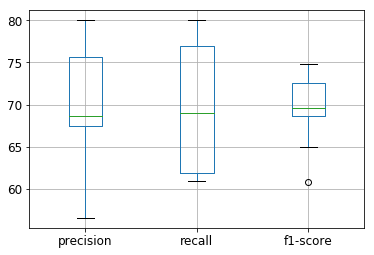

In [43]:
df_val_scores[["precision", "recall", "f1-score"]].boxplot()

In [44]:
df_val_variation_scores.iloc[df_val_variation_scores["f1-score"].idxmax()]

f1-score                                     74.7664
jobname      ppi-bert-untype-2020-03-09-03-23-07-482
precision                                    73.3945
recall                                       76.1905
Name: 7, dtype: object

In [45]:
best_val_job = df_val_variation_scores.iloc[df_val_variation_scores["f1-score"].idxmax()]["jobname"]

In [46]:
def download_single_file(bucket_name_path, local_path):
    index = bucket_name_path.find("://")

    # remove the s3:// if present
    if index > -1:
        bucket_name_path = bucket_name_path[index + 3:]

    key_start_index = bucket_name_path.find("/")
    bucket_name = bucket_name_path
    key = "/"
    if key_start_index > -1:
        bucket_name = bucket_name_path[0:key_start_index]
        key = bucket_name_path[key_start_index + 1:]
        
    client = boto3.resource('s3')
    client.Bucket(bucket_name).download_file(key, local_path)


def load_scores_as_df (file):
    with open(file, "r") as i:
        data = json.loads(i.read())
        
    return json_normalize(data)
    
def get_predictions(s3_path):
    tmp_dir = tempfile.mkdtemp()
    outfile = os.path.join(tmp_dir, "output.tar.gz" )
    download_single_file(s3_path, outfile)
    tf = tarfile.open(outfile)
    tf.extractall(path=tmp_dir)
    test_input_file = os.path.join(tmp_dir, "predicted.json")


    df_results =  pd.read_json(test_input_file)
    df_results["actual"] = df_results["isValid"]
    
    validation_fit_file = glob.glob("{}/validation_scores_epoch_Objectdump*.json".format(tmp_dir))[0]
    train_fit_file = glob.glob("{}/training_scores_epoch_Objectdump*.json".format(tmp_dir))[0]

    df_val_fit = load_scores_as_df(validation_fit_file)
    df_train_fit = load_scores_as_df(train_fit_file)



    return df_results, df_val_fit, df_train_fit

def get_all_scores (list_of_s3_path):
    scores = []

    for s3_path in list_of_s3_path:
        df,_,_ = get_predictions(s3_path) 
        score = {}
        score["key"]=s3_path
        score["F1-score"] = 100*f1_score(df["actual"], df["predicted"], average='binary' ,sample_weight=None)  
        score["Precision"]  =100* precision_score(df["actual"], df["predicted"], average='binary' ,sample_weight=None)  
        score["Recall"] = 100*recall_score(df["actual"], df["predicted"], average='binary' ,sample_weight=None) 
        score["Accuracy"] = 100*accuracy_score(df["actual"], df["predicted"])  


        scores.append(score)
        
    return pd.DataFrame(scores)


def get_ensemble (list_of_s3_path):
    scores = {}

    for s3_path in list_of_s3_path:
        df,_,_ = get_predictions(s3_path) 
        scores[s3_path] = df
        
    return scores

In [47]:
%%time

s3_model_paths = []
for k in jobs:
    s3_path = s3_model_path_format.format(k)
    s3_model_paths.append(s3_path)

df_test_variation_scores =  get_all_scores(s3_model_paths)

CPU times: user 861 ms, sys: 185 ms, total: 1.05 s
Wall time: 47.6 s


In [48]:
df_test_variation_scores.describe()

,Accuracy,F1-score,Precision,Recall
count,10.000000,10.000000,10.000000,10.000000
mean,86.118568,67.631668,73.430150,63.155340
std,1.549440,3.745644,5.267773,5.978083
min,82.438479,61.613692,62.068966,50.970874
25%,85.738255,65.140249,71.082512,60.072816
50%,86.689038,68.840301,73.872245,62.864078
75%,87.164430,69.757649,75.877193,68.325243
max,87.472036,71.921182,80.921053,70.873786


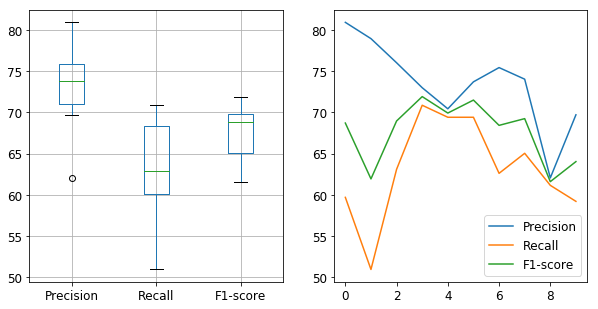

In [49]:

fig, ax = plt.subplots(1,2, figsize=(10, 5))

df_test_variation_scores[["Precision", "Recall", "F1-score"]].boxplot(ax=ax[0])
df_test_variation_scores[["Precision", "Recall", "F1-score"]].plot(ax = ax[1])

plt.savefig("score_variation.eps", bbox_inches='tight')



In [50]:
df_test_variation_scores.query("key == '{}'".format(s3_model_path_format.format(best_val_job)))

,Accuracy,F1-score,Precision,Recall,key
7,86.689038,69.250646,74.033149,65.048544,s3://aegovan-data/results/ppi-bert-untype-2020-03-09-03-23-07-482/output/output.tar.gz


In [51]:
%%time

s3_model_paths = []
for k in jobs:
    job_name = k 
    s3_path = s3_model_path_format.format(job_name)
    s3_model_paths.append(s3_path)

ensemble_results =  get_ensemble(s3_model_paths)

CPU times: user 807 ms, sys: 193 ms, total: 1 s
Wall time: 46.1 s


In [53]:
import math
def populate_predicted_confidence(df):
    keys = list(df["confidence_scores"][0].keys())
    # This is log softmax, convert to softmax prob
    for k in keys:
        df[k]  =df["confidence_scores"].apply(lambda x: math.exp(x[k]))
        df[k]  =df["confidence_scores"].apply(lambda x: math.exp(x[k]))

    df["predicted_confidence"] = df.apply(lambda r: max(r[ keys]/ sum(r[ keys])), axis=1 )

In [63]:
list(ensemble_results.values())[0]["confidence_scores"].iloc[0]

{'False': 2.1086540222, 'True': -1.9104254246}

In [94]:
vote_base="votes_{}"
def populate_ensemble_predicted_confidence(ensemble_results_dict):
    ensemble_results = list(ensemble_results_dict.values())
    base_df= ensemble_results[0]
    keys = list(base_df["confidence_scores"][0].keys())
    
    vote_keys = [ vote_base.format(k) for k in keys]
    result = base_df[["actual"]  ]
    result["index"] = base_df.index
    for v in vote_keys + keys:
        result[v] = 0.0
    # This is log softmax, convert to softmax prob
    for df in ensemble_results:
        for k in keys:
            populate_predicted_confidence(df)
        
            result.loc[:,k] = result.loc[:,k] +  df[k]
            result.loc[:,vote_base.format(k)] = result.loc[:,vote_base.format(k)]  + df.apply(lambda r: 1 if r["predicted"] == k else 0 , axis=1)


            
    
    # populate voting
    result.loc[:,"ensemble_predicted_confidence"] =  result.apply(lambda r: max(r[ keys]/ sum(r[ keys])), axis=1 )
    result.loc[:,"ensemble_predicted"] =  result.apply(lambda r: keys[list(r[ keys]).index(max(r[ keys]))] == 'True' , axis=1  )


    result.loc[:,"ensemble_majority_prediction"] = result.apply(lambda r: keys[list(r[ vote_keys]).index(max(r[ vote_keys]))] , axis=1 )
    result.loc[:,"ensemble_confidence_majority_prediction"] = result.apply(lambda r: r[r["ensemble_majority_prediction"]], axis=1 )
    result.loc[:,"ensemble_majority_prediction"]  = result.apply(lambda r : r["ensemble_majority_prediction"] == 'True',  axis=1 )
    return result

In [95]:
df_ensemble = populate_ensemble_predicted_confidence(ensemble_results)

/Users/aeg/miniconda/envs/kegg_env/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Users/aeg/miniconda/envs/kegg_env/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


In [96]:
df_ensemble.dtypes

actual                                        bool
index                                        int64
votes_False                                float64
votes_True                                 float64
False                                      float64
True                                       float64
ensemble_predicted_confidence              float64
ensemble_predicted                            bool
ensemble_majority_prediction                  bool
ensemble_confidence_majority_prediction    float64
dtype: object

In [97]:
df_ensemble["ensemble_predicted"].unique()

array([False,  True])

In [98]:
from sklearn.metrics import f1_score, accuracy_score,precision_score, recall_score

f1 = f1_score(df_ensemble["actual"], df_ensemble["ensemble_predicted"], average="binary")  
accuracy = accuracy_score(df_ensemble["actual"], df_ensemble["ensemble_predicted"], sample_weight=None)
precision = precision_score(df_ensemble["actual"], df_ensemble["ensemble_predicted"], average="binary", sample_weight=None)
recall = recall_score(df_ensemble["actual"], df_ensemble["ensemble_predicted"], average="binary", sample_weight=None)



print("The F1 score is {} and the accuracy is {}, precision {}, recall {}".format(f1, accuracy, precision, recall))

The F1 score is 0.7169811320754716 and the accuracy is 0.8825503355704698, precision 0.806060606060606, recall 0.6456310679611651
